In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

In [2]:
# Load the preprocessed data
X_train = pd.read_csv('X_train.csv', index_col=0)
X_test = pd.read_csv('X_test.csv', index_col=0)
y_train = pd.read_csv('y_train.csv', index_col=0)
y_test = pd.read_csv('y_test.csv', index_col=0)

In [3]:
# Normalize the data
scaler_X = MinMaxScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

scaler_y = MinMaxScaler()
y_train_scaled = scaler_y.fit_transform(y_train)
y_test_scaled = scaler_y.transform(y_test)

In [4]:
# Reshape input data for CNN (samples, time steps, features)
X_train_reshaped = X_train_scaled.reshape((X_train_scaled.shape[0], X_train_scaled.shape[1], 1))
X_test_reshaped = X_test_scaled.reshape((X_test_scaled.shape[0], X_test_scaled.shape[1], 1))

In [5]:
# Define the CNN model
def create_cnn_model(input_shape):
    model = Sequential([
        Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=input_shape),
        MaxPooling1D(pool_size=2),
        Conv1D(filters=32, kernel_size=3, activation='relu'),
        MaxPooling1D(pool_size=2),
        Flatten(),
        Dense(50, activation='relu'),
        Dropout(0.2),
        Dense(1)
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
    return model

In [6]:
# Create and train the CNN model
model = create_cnn_model((X_train_reshaped.shape[1], 1))
early_stopping = EarlyStopping(patience=10, restore_best_weights=True)
history = model.fit(X_train_reshaped, y_train_scaled, 
                    epochs=100, batch_size=32, 
                    validation_split=0.2, 
                    callbacks=[early_stopping], 
                    verbose=1)

Epoch 1/100
349/349 [==============================] - 3s 4ms/step - loss: 0.0250 - val_loss: 0.0824
Epoch 2/100
349/349 [==============================] - 1s 4ms/step - loss: 0.0191 - val_loss: 0.0655
Epoch 3/100
349/349 [==============================] - 1s 3ms/step - loss: 0.0181 - val_loss: 0.0740
Epoch 4/100
349/349 [==============================] - 1s 3ms/step - loss: 0.0175 - val_loss: 0.0845
Epoch 5/100
349/349 [==============================] - 1s 3ms/step - loss: 0.0169 - val_loss: 0.1127
Epoch 6/100
349/349 [==============================] - 1s 3ms/step - loss: 0.0166 - val_loss: 0.0916
Epoch 7/100
349/349 [==============================] - 1s 3ms/step - loss: 0.0163 - val_loss: 0.1249
Epoch 8/100
349/349 [==============================] - 1s 3ms/step - loss: 0.0160 - val_loss: 0.0788
Epoch 9/100
349/349 [==============================] - 1s 3ms/step - loss: 0.0158 - val_loss: 0.0740
Epoch 10/100
349/349 [==============================] - 1s 3ms/step - loss: 0.0156 - val_lo

In [7]:
# Make predictions
predictions_scaled = model.predict(X_test_reshaped)
predictions = scaler_y.inverse_transform(predictions_scaled)

109/109 [==============================] - 0s 2ms/step


In [8]:
# Evaluate the model
mse = mean_squared_error(y_test, predictions)
mae = mean_absolute_error(y_test, predictions)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, predictions)

print(f"Mean Squared Error: {mse}")
print(f"Mean Absolute Error: {mae}")
print(f"Root Mean Squared Error: {rmse}")
print(f"R-squared Score: {r2}")

Mean Squared Error: 0.04206117132632466
Mean Absolute Error: 0.1818981064935163
Root Mean Squared Error: 0.2050882037717544
R-squared Score: -7.886166402010067


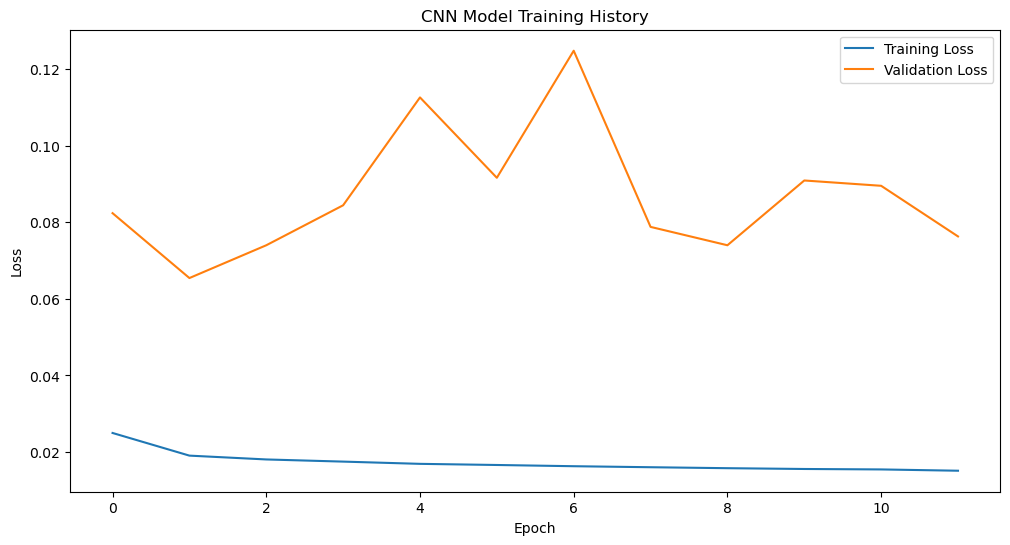

In [9]:
# Plot training history
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('CNN Model Training History')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

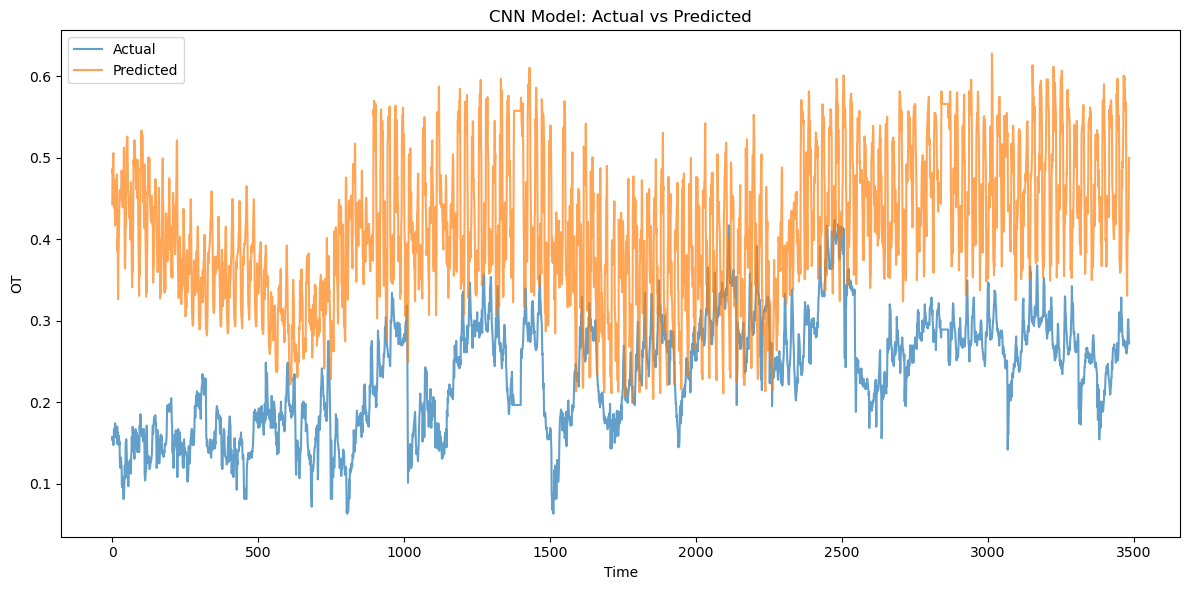

In [10]:
# Plot predictions vs actual
plt.figure(figsize=(12, 6))
plt.plot(y_test.values, label='Actual', alpha=0.7)
plt.plot(predictions, label='Predicted', alpha=0.7)
plt.title('CNN Model: Actual vs Predicted')
plt.xlabel('Time')
plt.ylabel('OT')
plt.legend()
plt.tight_layout()
plt.show()

ValueError: x and y must be the same size

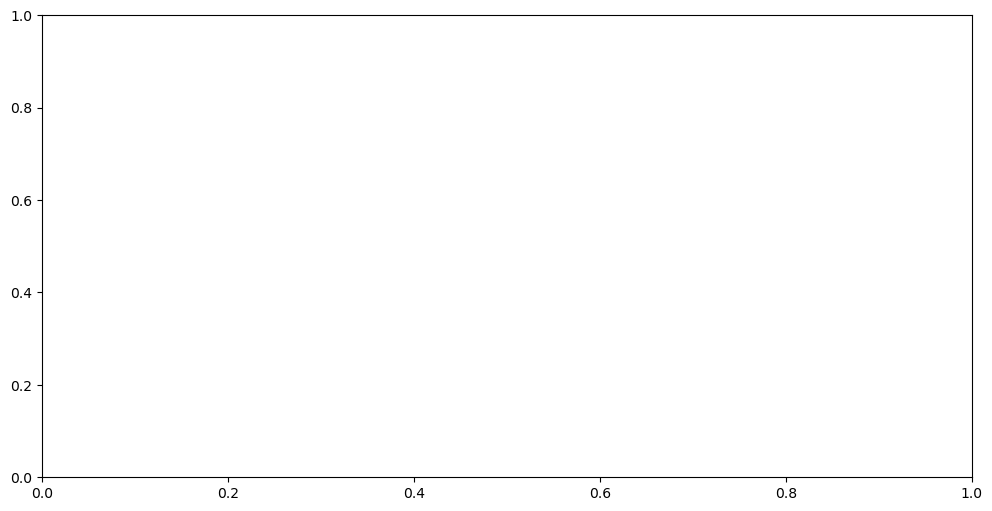

In [11]:
# Plot residuals
residuals = y_test.values - predictions.flatten()
plt.figure(figsize=(12, 6))
plt.scatter(predictions, residuals, alpha=0.5)
plt.title('CNN Model: Residuals Plot')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.axhline(y=0, color='r', linestyle='--')
plt.tight_layout()
plt.show()

In [ ]:
# Visualize filter activations (feature maps)
layer_outputs = [layer.output for layer in model.layers if 'conv1d' in layer.name.lower()]
activation_model = tf.keras.models.Model(inputs=model.input, outputs=layer_outputs)

activations = activation_model.predict(X_test_reshaped[:1])  # Get activations for the first test sample

for i, activation in enumerate(activations):
    plt.figure(figsize=(15, 5))
    plt.title(f'Activations of Convolutional Layer {i+1}')
    plt.imshow(activation[0].T, aspect='auto', cmap='viridis')
    plt.colorbar()
    plt.xlabel('Time Step')
    plt.ylabel('Filter')
    plt.tight_layout()
    plt.show()